In [21]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [23]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [24]:
np.random.seed(1234)

In [25]:
plt.style.use('classic')

In [26]:
import math

def intra_cluster_similarity(vectors):
    matx = scipy.sparse.vstack((vectors))
    return np.sum(cosine_similarity(matx, matx)) / math.pow(len(vectors), 2)

In [27]:
def intra_cluster_overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            similarity_topics[k] = intra_cluster_similarity(values)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [28]:
def intra_cluster_weighted_similarity(vectors):
    weighted = 0.
    n = 0.
    for k, values in vectors.items():
        n += len(values)
            
    for k, values in vectors.items():
        if len(values) > 0:
            weighted += len(values) * intra_cluster_similarity(values)

    return weighted / n

In [29]:
def inter_cluster_overall_similarity2(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        if len(values) > 0:
            matx = scipy.sparse.vstack((values))
            centroid1 = matx.sum(axis=0) / len(values)
            similarities = []
            for k2, values2 in vectors.items():
                if len(values2) > 0 & k != k2:
                    matx2 = scipy.sparse.vstack((values2))
                    centroid2 = matx2.sum(axis=0) / len(values2)
                    similarities.append(cosine_similarity(centroid1, centroid2))
            similarity_topics[k] = np.sum(similarities) / len(similarities)
            
    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [30]:
def cluster_centroids(vectors):
    centroids = {}
    for k, values in vectors.items():
        matx = scipy.sparse.vstack((values))
        centroids[k] = scipy.sparse.csr_matrix(matx.sum(axis=0) / len(values))
    return centroids

In [31]:
def inter_cluster_overall_similarity(vectors):
    topic_centroids = cluster_centroids(vectors)
    matx_c = scipy.sparse.vstack((topic_centroids.values()))
    matx_c_c = cosine_similarity(matx_c)
    matx_c_c_s = sum(matx_c_c) / len(matx_c_c)

    return sum(matx_c_c_s) / len(matx_c_c_s)

In [32]:
def purity_score(labels_true):
    nh = np.bincount(labels_true)

    return nh[np.argmax(nh)] / sum(nh)

In [33]:
def entropy_score(labels_true):
    entropy = 0.
    cats = np.unique(labels_true)
    ci = len(cats)
    if ci == 1: # math.log(1,2) == 0.0, causes div by zero when normalizing
        ci += 1
    nh = np.bincount(labels_true)
    n = len(labels_true)
    
    for j in cats:
        p_category = nh[j] / n
        entropy += p_category * math.log(p_category, 2)
    
    return -((1 / math.log(ci, 2)) * entropy)

In [34]:
def entropy_weighted_score(labels_size, labels_true):
    entropy = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        try:
            n += len(labels_true[i])
        except:
            n += 0.
        
    for i in (np.arange(labels_size) + 1):
        try:
            labels_true_topic = labels_true[i]
            ni = len(labels_true_topic)
            entropy += (ni / n) * entropy_score(labels_true_topic)
        except:
            entropy += 0.
    return entropy

In [35]:
def purity_weighted_score(labels_size, labels_true):
    purity = 0.
    n = 0.
    for i in (np.arange(labels_size) + 1):
        try:
            n += len(labels_true[i])
        except:
            n += 0.
        
    for i in (np.arange(labels_size) + 1):
        try:
            labels_true_topic = labels_true[i]
            ni = len(labels_true_topic)
            purity += (ni / n) * purity_score(labels_true_topic)
        except:
            purity += 0.
    return purity

In [36]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [37]:
def text_preprocess(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [38]:
import re

#compile regular expressions that match repeated characters and emoji unicode
emoji = re.compile(u'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]',re.UNICODE)
multiple = re.compile(r"(.)\1{1,}", re.DOTALL)

def text_format(text):

    #strip emoji
    stripped = emoji.sub('',text)

    #strip URLs
    stripped = re.sub(r'http[s]?[^\s]+','', stripped)

    #strip html '&amp;', '&lt;', etc.  
    stripped = re.sub(r'[\&].*;','',stripped)

    #strip punctuation
    stripped = re.sub(r'[#|\!|\-|\+|:|//]', " ", stripped)

    #strip whitespace down to one.
    stripped = re.sub('[\s]+' ,' ', stripped).strip()

    #strip multiple occurrences of letters
    stripped = multiple.sub(r"\1\1", stripped)

    #strip all non-latin characters
    stripped = re.sub('[^a-zA-Z0-9|\']', " ", stripped).strip()

    return stripped

In [19]:
from gensim import matutils
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from nltk.tag import pos_tag

print("Building vocabulary...")

docs = {}
doc_tokens = {}
count = 0

for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            text = text_format(text)
            tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
            words = [word for word,pos in tagged if pos in ['NN', 'NNS', 'NNP', 'NNPS']]
            docs[doc['id']]["text"] = " ".join(words)
            clear_output(wait=True)
            count += 1
            print(count)

9095


In [39]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['body', 'mod_topic', 'tfidf', 'authors', 'top_tfidf', 'id', 'apiUrl', 'webUrl', 'tags', 'guardianId', 'keyword', 'section_id', 'text', 'webTitle', 'webPublicationDate', 'sectionId'])

In [40]:
token_keys = [x[0] for x in docs.items()]
token_values = [x[1]["text"] for x in docs.items()]
print(len(token_values))

9095


# TF-IDF Vectorizer

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(token_values)

print(X_tfidf.shape)

Processing TF-IDF
(9095, 69281)


In [22]:
pickle.dump(X_tfidf, open('tmp/X_tfidf.pickle', 'wb'))

In [21]:
X_tfidf = pickle.load(open('tmp/X_tfidf.pickle', 'rb'))

print(X_tfidf.shape)

(9095, 69281)


# Add Keywords to docs

In [61]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [62]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [63]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['top_tfidf'] = top_feats_in_doc(X_tfidf, vectorizer_tfidf.get_feature_names(), i, 50)
    
print(docs['2016-05-20-28']['top_tfidf'])

       feature     tfidf
0         bull  0.367068
1         citi  0.332301
2       soccer  0.289241
3           fc  0.209085
4         team  0.207811
5           ml  0.203020
6          fan  0.192072
7         york  0.179047
8      stadium  0.176389
9        derbi  0.165884
10      jersey  0.162874
11         esc  0.161058
12        club  0.151384
13     rivalri  0.141493
14       yanke  0.131158
15     support  0.121895
16       giant  0.117103
17      hudson  0.115708
18    ferrezza  0.112200
19       river  0.105877
20         nyc  0.099118
21        rail  0.095774
22       sport  0.086328
23      yorker  0.075947
24       metro  0.073635
25   manhattan  0.070209
26        tide  0.067413
27     borough  0.065498
28    franchis  0.062221
29       villa  0.059946
30       pride  0.058486
31       group  0.057858
32   hungerusa  0.056100
33      emmitt  0.056100
34     yorknew  0.056100
35     transit  0.054849
36       jeter  0.053686
37  sportscast  0.053686
38     tailgat  0.051973


# Add Vector to docs

In [24]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]

docs['2016-05-20-28']['tfidf']

<1x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 196 stored elements in Compressed Sparse Row format>

# Add Section ID to docs

In [22]:
section_id = {}
count = 0
for k, v in docs.items():
    try:
        section_id[v['sectionId']]
    except:
        count += 1
        section_id[v['sectionId']] = count
        
len(section_id.values())

84

In [23]:
for k, v in docs.items():
    docs[k]['section_id'] = section_id[v['sectionId']]

# Add Keyword

In [115]:
for k, v in docs.items():
    docs[k]['tags'] = []
    for keyword in v['keyword']:
        docs[k]['tags'].append(keyword['webTitle'])

docs['2016-05-20-28']['tags']

['MLS',
 'New York Red Bulls',
 'New York City FC',
 'US sports',
 'Football',
 'Sport']

In [116]:
def docs_to_tag_data(docs):
    d = []
    for key, vs in docs.items():
        h = {}
        for v in vs:
            h[v] = True
        d.append(h)

    return(d)

In [117]:
tag_values = docs_to_tag_data(docs)

# Save & Load Docs

In [69]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [22]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['webUrl', 'text', 'top_tfidf', 'authors', 'body', 'section_id', 'keyword', 'mod_topic', 'apiUrl', 'tfidf', 'id', 'sectionId', 'webTitle', 'guardianId', 'tags', 'webPublicationDate'])

# Apply Modularity

In [41]:
sub_g = ig.Graph.Read_GML('tmp/sg_02.gml')

In [42]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
    print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
    print("APL {}".format(g.average_path_length()))
    print("AD {}".format(sum(g.degree())/len(g.degree())))
    print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [43]:
threshold = np.average(cosine_similarity(X_tfidf))
threshold

NameError: name 'X_tfidf' is not defined

In [44]:
sg = sub_g.es.select(weight_ge=0.2).subgraph()
communities = sg.community_multilevel(weights='weight',return_levels=True)
for com in communities:
    print(max(com.membership) + 1)
community = communities[-1]
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))
print("LCC {}".format(sg.clusters().giant().vcount()))
print("NO of Communities {}".format(max(community.membership) + 1))
print("Modularity {}".format(sg.modularity(community.membership)))
# community = sg.community_infomap(edge_weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

586
166
140
139
Nodes 8213
Edges 132243
LCC 7950
NO of Communities 139
Modularity 0.7987487477056004


In [28]:
sg.write_gml('tmp/sg_02.gml')

# Reduced Data

In [46]:
reduced_docs = {}
for v in sg.vs():
    reduced_docs[v['name']] = docs[v['name']]

In [47]:
sorted_reduced_docs = sorted(reduced_docs.items(), key=lambda x: x[0], reverse=True)

In [49]:
reduced_tfidf_values = [x[1]['tfidf'] for x in sorted_reduced_docs]

In [50]:
reduced_X_tfidf = scipy.sparse.vstack((reduced_tfidf_values))
reduced_X_tfidf

<8213x69281 sparse matrix of type '<class 'numpy.float64'>'
	with 1089809 stored elements in Compressed Sparse Row format>

In [51]:
reduced_token_keys = [x[0] for x in sorted_reduced_docs]
reduced_token_values = [x[1]["text"] for x in sorted_reduced_docs]
print(len(reduced_token_values))

8213


# Hierarchical Clustering

In [52]:
from scipy.cluster.hierarchy import dendrogram

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(reduced_X_tfidf)

In [416]:
X_tfidf.toarray()[:3]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [55]:
from scipy.cluster.hierarchy import average
from scipy.cluster.hierarchy import linkage

In [69]:
random.seed(7777)

In [70]:
print("Start Hierarchical Clustering...")

linkage_matrix = average(dist) #de fine the linkage_matrix using hierachical clustering pre-computed distances
# linkage_matrix = linkage(dist, metric='cosine', method='average')

print("Done Hierarchical Clustering...")

Start Hierarchical Clustering...
Done Hierarchical Clustering...


In [313]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(linkage_matrix, pdist(dist))
c

0.77491382903670991

In [71]:
pickle.dump(linkage_matrix, open('tmp/linkage_matrix_average2.pickle', 'wb'))

In [24]:
pickle.dump(dist, open('tmp/dist.pickle', 'wb'))

In [ ]:
linkage_matrix = pickle.load(open('tmp/linkage_matrix_average1.pickle', 'rb'))

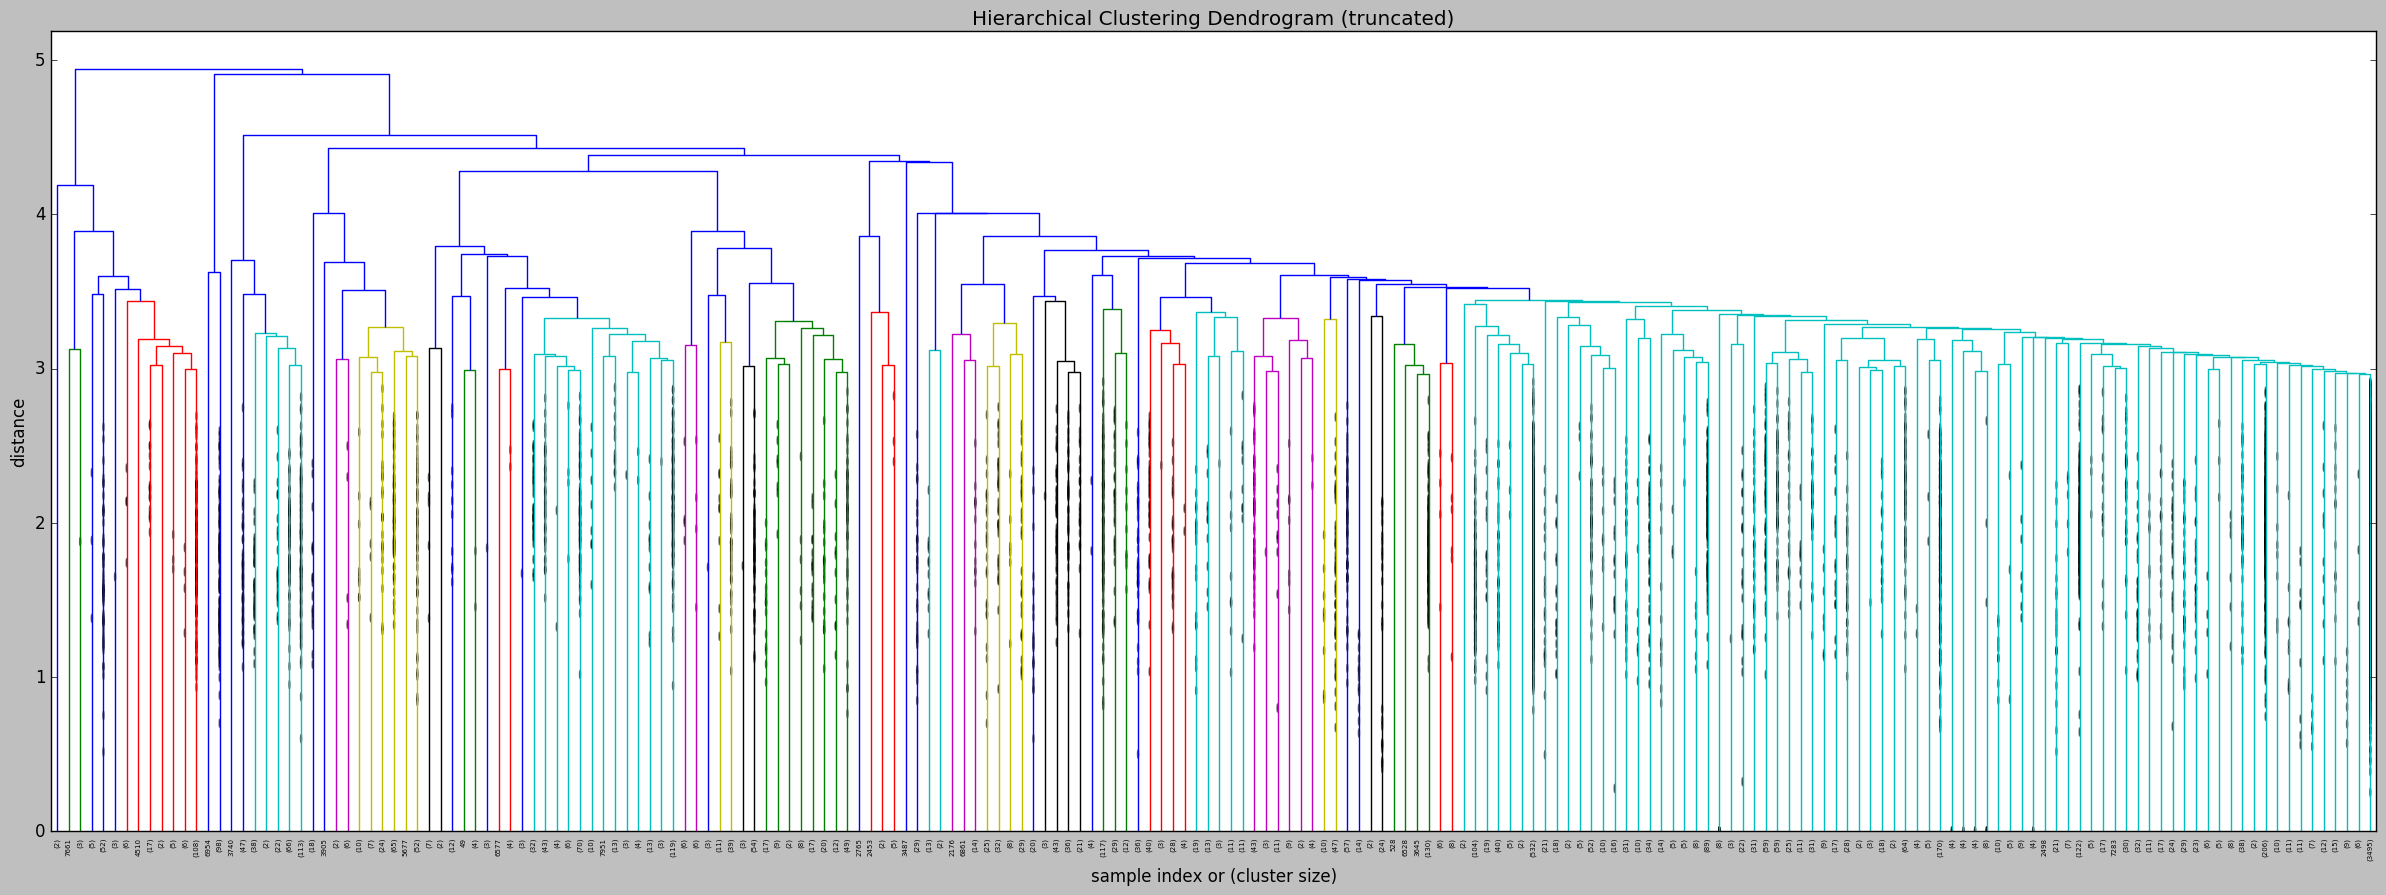

In [36]:
plt.figure(figsize=(30, 10))
fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=200,
    leaf_rotation=90.,
    leaf_font_size=5.,
    show_contracted=True,
    annotate_above=200,  # useful in small plots so annotations don't overlap
)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fclusterdata, fcluster

def cluster_indices(cluster_assignments):
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    return indices

# Compute the clusters.
cluster_assignments = fcluster(linkage_matrix, 50, criterion="maxclust")

# Print the indices of the data points in each cluster.
num_clusters = cluster_assignments.max()
print("%d clusters" % num_clusters)
indices = cluster_indices(cluster_assignments)

print("Giant Size:", len(max(indices, key=lambda x: len(x))))

# for k, ind in enumerate(indices):
#     print("cluster", k + 1, " (Length:)", len(ind), "=", ind)

for k, ind in enumerate(indices):
    for i in ind:
        reduced_docs[reduced_token_keys[i]]['hclust'] = k

In [73]:
hclust_items = []
for item in reduced_docs.items():
    hclust_items.append((item[0], item[1]['hclust']))
len(hclust_items)

8213

In [74]:
with open('tmp/hclust_docs.txt', 'w+') as file:
    for item in hclust_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['hclust'], item[0], item[1]['webTitle']))

TypeError: 'int' object is not subscriptable

In [75]:
topics = {}

for i in range(num_clusters):
    topics[i] = []
    
for item in hclust_items:
    topic_no = item[1]
    topics[topic_no].append(item[0])
    
print(len(topics.keys()))

hclust_topics = {}
count = 1
for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
    hclust_topics[count] = value
    count += 1

139


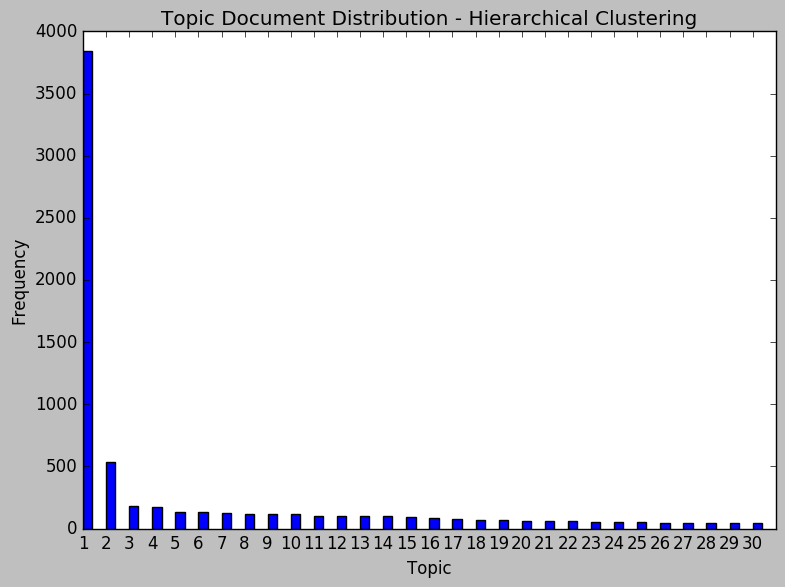

In [76]:
x_data = []
y_data = []
for key, value in sorted(hclust_topics.items(), key=lambda x: len(x[1]), reverse=True):
    if key <= 30:
        x_data.append(key)
        y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure()
plt.bar(ind, y_data)
plt.xticks(ind, x_data)
plt.title("Topic Document Distribution - Hierarchical Clustering")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.tight_layout()
fig.savefig('tmp/size_chart_hclust.png')
plt.show()

In [85]:
import scipy.stats as stats

def topics_to_prob_dist(topics):
    x_data = []
    y_data = []
    for key, value in topics.items():
        x_data.append(key)
        y_data.append(len(value))

    df = pd.DataFrame(y_data)
    # df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

    fig = plt.figure()
    plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))
    plt.title("Probability Distribution of Topic Sizes - Hierarchical Clustering")
    plt.xlabel("Topic Size")
    plt.ylabel("Probability")
    plt.tight_layout()
    fig.savefig('tmp/prob_chart_hclust.png')

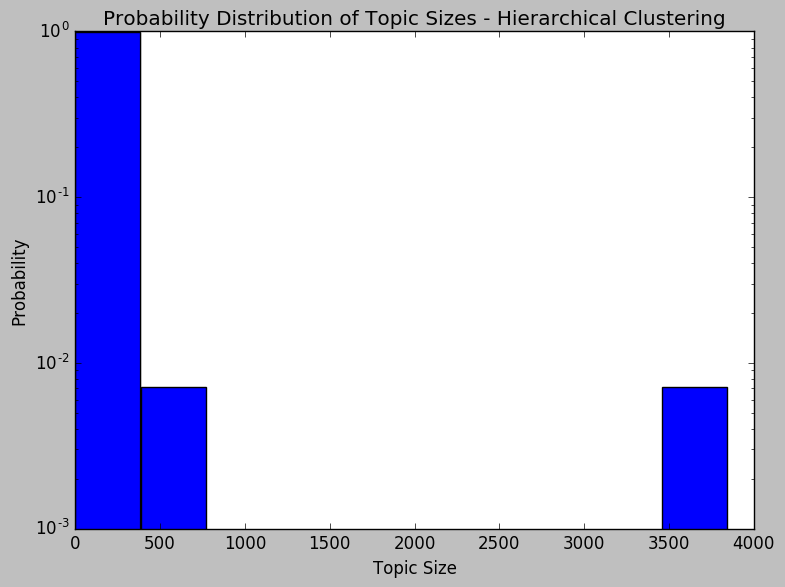

In [78]:
topics_to_prob_dist(hclust_topics)

In [79]:
np.max(y_data)

3841

In [80]:
np.average(y_data)

227.03333333333333

In [81]:
hclust_tfidf_topics = {}

for k, vs in hclust_topics.items():
    hclust_tfidf_topics[k] = []
    for v in vs:
        hclust_tfidf_topics[k].append(docs[v]['tfidf'])

In [82]:
hclust_labels_true = {}

for k, vs in hclust_topics.items():
    hclust_labels_true[k] = []
    for v in vs:
        hclust_labels_true[k].append(docs[v]['section_id'])

In [83]:
print("Overall Similarity {0:.3f}".format(intra_cluster_overall_similarity(hclust_tfidf_topics)))
print("Inter Cluster {0:.3f}".format(inter_cluster_overall_similarity(hclust_tfidf_topics)))

Overall Similarity 0.449
Inter Cluster 0.113


In [84]:
print("Intra")
for i in np.arange(10,140,10):
    print("{0:.3f}".format(intra_cluster_overall_similarity({k: v for k, v in hclust_tfidf_topics.items() if k <= i})), end=",")

print("\nInter")
for i in np.arange(10,140,10):
    print("{0:.3f}".format(inter_cluster_overall_similarity({k: v for k, v in hclust_tfidf_topics.items() if k <= i})), end=",")

Intra
0.143,0.182,0.202,0.227,0.244,0.264,0.291,0.297,0.319,0.329,0.351,0.378,0.411,
Inter
0.296,0.247,0.216,0.190,0.164,0.150,0.138,0.136,0.127,0.129,0.123,0.119,0.116,

In [56]:
len(hclust_labels_true[1])

3841

In [176]:
original_topics = {}
for k, v in docs.items():
    try:
        original_topics[v['section_id']]
    except:
        original_topics[v['section_id']] = []
    
    original_topics[v['section_id']].append(k)
        
len(original_topics.keys())

84

In [177]:
def topics_to_heatmap_data(topics):
    d = []
    for key, value in sorted(topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)

    return(d)

In [180]:
hclust_data = topics_to_heatmap_data(hclust_topics)
ori_data = topics_to_heatmap_data(original_topics)

In [181]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectors  = ori_data + hclust_data 
X_dict = vectorizer.fit_transform(vectors)

print(X_dict.shape)

(223, 9095)


In [190]:
ori_vectors = X_dict[0:len(ori_data)]
hclust_vectors = X_dict[len(ori_data):]

In [200]:
from sklearn.metrics.pairwise import cosine_similarity

sub_sims = cosine_similarity(X_dict[0:30], X_dict[len(ori_data):len(ori_data)+30])
sub_sims.shape

(30, 30)

In [201]:
def filter_max_in_sims(sims):
    sims = sims.copy()
    for sim in sims:
        low_values_indices = sim < np.amax(sim)
        sim[low_values_indices] = 0 
    return sims

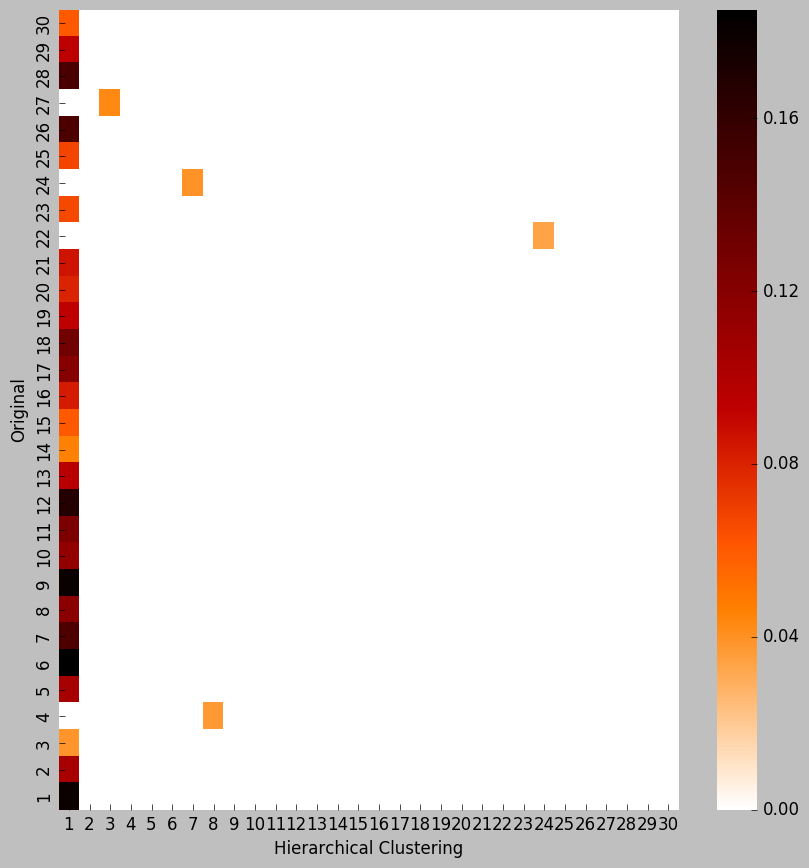

In [202]:
import seaborn as sns

filtered_sims = filter_max_in_sims(sub_sims)

fig, ax = plt.subplots(figsize=(10, 10))
sns_plt = sns.heatmap(filtered_sims, cmap=plt.cm.gist_heat_r)
sns_plt.set(xticklabels=np.arange(1,31), yticklabels=(-np.sort(-np.arange(1,31))))
sns_plt.invert_yaxis()
plt.xlabel("Hierarchical Clustering")
plt.ylabel("Original")